In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

In [27]:
# fishnets functions

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0))) + jnp.eye(n_params)




class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.swish(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

# load data

In [3]:
pwd

'/Users/lucas/repositories/fishnets_for_degenerates'

In [81]:
data = np.load('camb_TT_secret_params.npy')
theta_ = data[:, :6]
data = jnp.arcsinh(data)[:, 6:][:, ::4] # take every fourth bin (for now)

In [82]:
data.shape

(10000, 513)

In [83]:
key = jax.random.PRNGKey(0)

n_params = 6
n_outputs = int(n_params + int(n_params * (n_params + 1)) // 2)

theta_fid = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

model = MLP([128,128,128,n_outputs])

w = model.init(key, jnp.ones((513)))

outs = model.apply(w, jnp.ones((513)))

In [84]:
outs.shape

(27,)

In [85]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       outputs = model.apply(w, x)
       t = outputs[:n_params]
       f_cholesky = outputs[n_params:]
       F = construct_fisher_matrix_single(f_cholesky)

       # score jump step
       mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

       return mle, F
    
    mle,F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [86]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 100
epochs = 100

w = w

losses = []

In [112]:
from tqdm import tqdm
batch_size = 100
epochs = 300

key = jax.random.PRNGKey(99)

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)

  for i in range(len(data) // batch_size):
    x_samples = data[batch_size*i:(batch_size*(i+1))]
    y_samples = theta_[batch_size*i:(batch_size*(i+1))]

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    #if i % 10 == 0:

    #  val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)
      
  losses.append(loss_val)
  #val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f'%(j, loss_val))

epoch loss 32: -13.0634:  11%|█         | 33/300 [00:50<06:48,  1.53s/it]


KeyboardInterrupt: 

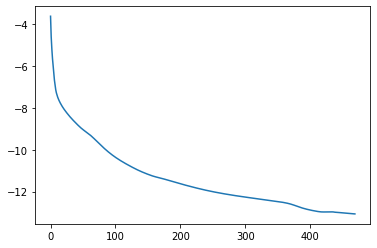

In [113]:
plt.plot(losses)

In [114]:
def get_mle_F(x):
    outputs = model.apply(w, x)
    t = outputs[:n_params]
    f_cholesky = outputs[n_params:]
    F = construct_fisher_matrix_single(f_cholesky)

    mle = jnp.einsum('jk,k->j', jnp.linalg.inv(F), t) + theta_fid

    return mle, F

In [115]:
mle_pred,F_pred = jax.vmap(get_mle_F)(data[-1000:])

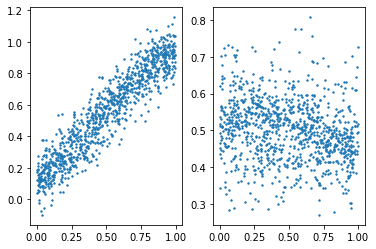

In [116]:
plt.subplot(121)
plt.scatter(theta_[-1000:, 0], mle_pred[:, 0], s=2)
plt.subplot(122)
plt.scatter(theta_[-1000:, 1], mle_pred[:, 3], s=2)

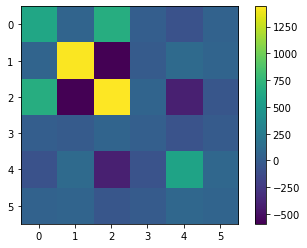

In [110]:
plt.imshow(F_pred.mean(0))
plt.colorbar()

In [106]:
F_pred[9]

Array([[ 537.62683 ,  437.44263 ,  301.52713 ,   10.467521,  -34.133343,
          83.3276  ],
       [ 437.44263 , 2584.6184  , -268.03476 ,   21.113724,  273.588   ,
         308.28973 ],
       [ 301.52713 , -268.03476 ,  499.98938 ,   28.353884, -280.69434 ,
         -71.01551 ],
       [  10.467521,   21.113724,   28.353884,   18.822083,  -49.45488 ,
          -5.0153  ],
       [ -34.133343,  273.588   , -280.69434 ,  -49.45488 ,  449.958   ,
          86.842896],
       [  83.3276  ,  308.28973 ,  -71.01551 ,   -5.0153  ,   86.842896,
          93.779495]], dtype=float32)